### Step 2. The Split (The Firewall): Split the data 

First will split data and then We will follow below steps to handle 'unknown' values from "job', 'education','contact' and 'poutcome' columns.
First, calculate the percentage of "unknown" values in each column to understand the extent of the issue.

"Pro-Tip" for Banking
When perform Train-Test Split, always use Stratification.

In our bank-full dataset, "Success" (y=1) is likely rare (around 11-12%). If a random split done without stratification, it might end up with 15% success in Train and only 5% in Test. This will make evaluation metrics (like Precision/Recall) completely unreliable

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the training data we processed earlier
df = pd.read_csv('../data/processed/df_processed.csv')

In [8]:
from sklearn.model_selection import train_test_split

# Always stratify by the target variable 'y' in banking
X = df.drop('y', axis=1)
y = df['y']
# 80/20 Split with Stratification (keeps failure ratio consistent)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (36168, 20)
Test set size: (9043, 20)


Now, we have

Train data = X_train, y_train 
Test data = X_test, y_test

Feature Engineering

Now, will perform Data cleaning, feature engineering and EDA only on train data : X_train, y_train

In [15]:
# Combine X and y back together for cleaning, featurization, EDA and Modeling storage
df_train = pd.concat([X_train, y_train], axis=1)

# Save to processed directory
# train_full.to_csv('../data/processed/train_processed.csv', index=False)
# test_full.to_csv('../data/processed/test_processed.csv', index=False)

# print("Data cleaning and feature engineering complete. Files saved to data/processed/.")

df_train.info()


<class 'pandas.DataFrame'>
Index: 36168 entries, 24001 to 44229
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              36168 non-null  int64  
 1   job              36168 non-null  str    
 2   marital          36168 non-null  str    
 3   education        36168 non-null  str    
 4   default          36168 non-null  str    
 5   balance          36168 non-null  int64  
 6   housing          36168 non-null  str    
 7   loan             36168 non-null  str    
 8   contact          36168 non-null  str    
 9   day              36168 non-null  int64  
 10  month            36168 non-null  str    
 11  duration         36168 non-null  int64  
 12  campaign         36168 non-null  int64  
 13  pdays            36168 non-null  int64  
 14  previous         36168 non-null  int64  
 15  poutcome         36168 non-null  str    
 16  total_contacts   36168 non-null  int64  
 17  call_efficiency  36168 n

### Part B Data Cleaning only on train data after spliting data in to train and test.

1. Impute: Replace unknown in job or education with the mode.
2. Handle Outliers: Cap the extreme balance values (Capping/Winsorization).

**Step 3. Statistical Modeling Cleaning: Post-Split**

Now in the Lab.

- Imputation/Scaling: You calculate the "Standard" (Mean/Mode) from the Train set. If the Test set has a missing value, you fill           it with the Train mode. This mimics the real world, where you use past knowledge to handle new, incomplete information.

- Handling Outliers

- Bivariate EDA & Heatmaps: By doing this only on the training set, you ensure that your decision to keep or drop a feature is based only on the data the model is allowed to learn from.

**Do these AFTER splitting:**

1. Handling Outliers: Defining what an outlier is based on the training distribution.
2. Imputation: Filling missing values using the mean, median, or mode of the training set only.
3. Scaling/Normalization: If you normalize based on the global maximum, you've leaked the range of the test set into your training process.
4. EDA: Visualizing correlations and distributions to decide which features to keep.

In [16]:
# 4. Impute: Replace unknown in job or education with the mode.
# selected only categorical columns

categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']

# count unknown values in each column

unknown_counts = df_train[categorical_columns].apply(lambda col: (col == "unknown").sum())

print(unknown_counts) # the output will give unknown counts for each categorical columns

job            234
marital          0
education     1482
default          0
housing          0
loan             0
contact      10386
month            0
poutcome     29589
y                0
dtype: int64


In [18]:
# # Calculate the percentage of 'unknown' values in each relevant column
columns_with_unknowns = ['job', 'education', 'poutcome', 'contact']
for col in columns_with_unknowns:
    unknown_count = df_train[df_train[col] == 'unknown'].shape[0]
    total_count = df.shape[0]
    percentage = (unknown_count / total_count) * 100
    print(f"Column: {col}, Unknown Values: {unknown_count}, Percentage: {percentage:.2f}%")


Column: job, Unknown Values: 234, Percentage: 0.52%
Column: education, Unknown Values: 1482, Percentage: 3.28%
Column: poutcome, Unknown Values: 29589, Percentage: 65.45%
Column: contact, Unknown Values: 10386, Percentage: 22.97%


**job and education:**  These are likely important features for predicting the target.
the percentage of unknown values in 'job' and 'education' are 0.52% and 3.28%. which are very low.

We will replace 'unknown' rows with mode value of that column.

**contact and poutcome:**

the percentage of unknown values in 'contact' and 'poutcome' are 0.22.97% and 65.45%. which are very low.

'poutcome' columns have a high proportion (>30%) of "unknown" values and if their **impact** on the target variable (y) seems minimal, then we can remove them entirely.

Let's check impact of 'contact' and 'potcome' on the target variable(y).


**Perform Chi-Square Test (Categorical Association)**

A chi-square test can help determine whether there is a statistically significant association between the column (contact or poutcome) and the target variable (y).

Interpretation:
A p-value < 0.05 indicates a statistically significant relationship between the column and the target variable (y).
A high p-value (>0.05) suggests the column has little impact on the target.


In [19]:
from scipy.stats import chi2_contingency

# Create contingency tables for 'contact' and 'poutcome'
contact_table = pd.crosstab(df_train['contact'], df_train['y'])
poutcome_table = pd.crosstab(df_train['poutcome'], df_train['y'])

# Perform chi-square test
contact_chi2, contact_p, _, _ = chi2_contingency(contact_table)
poutcome_chi2, poutcome_p, _, _ = chi2_contingency(poutcome_table)

print(f"Contact - Chi-square p-value: {contact_p}")
print(f"Poutcome - Chi-square p-value: {poutcome_p}")


Contact - Chi-square p-value: 2.2216425534984923e-177
Poutcome - Chi-square p-value: 0.0


**Perform Chi-Square Test (Categorical Association)**

A chi-square test can help determine whether there is a statistically significant association between the column (contact or poutcome) and the target variable (y).

Interpretation:
A p-value < 0.05 indicates a statistically significant relationship between the column and the target variable (y).
A high p-value (>0.05) suggests the column has little impact on the target.


In [20]:
check= [contact_p, poutcome_p] 

for col in check:
    if col >= 0.05:
        print("there is no association with", col)
    else:
        print("there is significant association with ", col)

there is significant association with  2.2216425534984923e-177
there is significant association with  0.0


Conclusion: we will retain the 'contact' and 'poutcome' columns from the data df_train. 
We have two options: 
1. continue as is with 'unkown' values
2. replace 'unknown' values by mode value of that column.

In [21]:
# finding mode for 'contact' and 'potcome'
mode_contact = df_train['contact'].mode()[0]
mode_poutcome = df_train['poutcome'].mode()[0]

print("mode value of contact : ", mode_contact)
print("mode value of poutcome: ", mode_poutcome)

# finding mode for 'job' and 'education'
mode_job = df_train['job'].mode()[0]
mode_education = df_train['education'].mode()[0]
print("mode value of job : ", mode_job)
print("mode value of education: ", mode_education)


mode value of contact :  cellular
mode value of poutcome:  unknown
mode value of job :  blue-collar
mode value of education:  secondary


In [28]:
# Replacing 'unknow' values by relevant column's mode value
# We will keep poutcome "unknowm" values as is because the model will learn that "unknown" actually means "new customer."
df_cleaned=df_train
for col in ['job', 'education','contact']:
    mode_value = df_train[col].mode()[0]
    df_cleaned[col] = df_cleaned[col].replace('unknown',mode_value)
    #print(df_cleaned[col])


print("Cleaning 'unknown' values imputed with relevant mode value.")   

Cleaning 'unknown' values imputed with relevant mode value.


In [31]:
# # 1. Identify columns for Mode Imputation
# impute_cols = ['job', 'education']

# for col in impute_cols:
#     # Calculate mode ONLY on Training set
#     train_mode = X_train[col].mode()[0]
    
#     # Replace 'unknown' in both sets
#     X_train[col] = X_train[col].replace('unknown', train_mode)
#     X_test[col] = X_test[col].replace('unknown', train_mode)

# 2. Rename 'unknown' in poutcome to keep the signal
# This prevents 'unknown' from being treated as a missing value
df_train['poutcome'] = df_train['poutcome'].replace('unknown', 'other_outcome')
X_test['poutcome'] = X_test['poutcome'].replace('unknown', 'other_outcome')

print("Imputation complete using Training Set statistics.")

Imputation complete using Training Set statistics.


**Professional Outlier Handling: Capping**

Handle Outliers: Cap the extreme balance values (Capping/Winsorization).

Logic: don't just delete the outliers (that way we may lose too much data). Instead, cap them at the 99th percentile. This keeps the "High Value" signal without letting the €102,127 balance break your model.

Capping vs. Deleting: In banking, we rarely delete outliers like a €102k balance. That person is a "High Net Worth" client! By Capping (using .clip()), we keep the customer in the dataset but prevent their high balance from "pulling" the average too far away from the typical customer.

we want our "Bivariate" plots to be accurate. If we don't cap outliers first, our scatter plots will look like a single dot because of the scale.

In [32]:
# 5. Handle Outliers (Capping / Winsorization)
#  Handle Outliers (capping): Cap the extreme balance values (Capping/Winsorization).
for col in ['balance', 'duration', 'campaign']:
    upper_limit = df_train[col].quantile(0.99)
    # We cap the values at the 99th percentile
    df_train[col] = np.where(df_train[col] > upper_limit, upper_limit, df_train[col])
    #or 
    # df_train[col] = df_train[col].clip(upper=upper_limit)


print("Outliers capped at 99th percentile for balance, duration, and campaign.")
print("Cleaning Complete: outliers are capped and unkown value handled. \nData is ready for Featurization(Feature Engineering) and EDA")

Outliers capped at 99th percentile for balance, duration, and campaign.
Cleaning Complete: outliers are capped and unkown value handled. 
Data is ready for Featurization(Feature Engineering) and EDA


In [38]:
print(df_train.columns)
df_train.info()

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'total_contacts', 'call_efficiency',
       'multiple_loans', 'is_new_customer', 'y'],
      dtype='str')
<class 'pandas.DataFrame'>
Index: 36168 entries, 24001 to 44229
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              36168 non-null  int64  
 1   job              36168 non-null  str    
 2   marital          36168 non-null  str    
 3   education        36168 non-null  str    
 4   default          36168 non-null  str    
 5   balance          36168 non-null  float64
 6   housing          36168 non-null  str    
 7   loan             36168 non-null  str    
 8   contact          36168 non-null  str    
 9   day              36168 non-null  int64  
 10  month            36168 non-null  str    
 11  duration  

# Feature Engineering

In a professional banking workflow, the order of Feature Engineering versus Bivariate EDA is a bit of a "chicken and egg" situation, but there is a preferred path for efficiency.

The industry-standard approach is to do Feature Engineering before Bivariate EDA.

Why this order?

If you create a feature like balance_per_campaign or age_groups first, you can include them in your Bivariate EDA and Heatmaps. This allows you to see if your newly created features actually have a stronger relationship with the target (y) than the raw data did.

Standard: Create new columns that are derived from row-level logic (e.g., balance_per_campaign or age_groups).

Why: These are based on business rules, not statistical distributions.

Status: Correct. You did this before the split.


**Summary Checklist for our Notebook:**

done: Cleaning: Fix the data (Mode imputation, Outlier capping).

current: Feature Engineering: Add new columns (derived from your SQL logic).

Next: EDA (Part B): Compare variables to y (Bivariate) and check correlations.

Split: Separate your data.

Scale: Normalize the numbers.

# Part B Exploratory Data Analysis 

Goal: Gain insights into the dataset and understand relationships between variables.

we are now in the "Discovery Phase." In a banking context, Bivariate EDA isn't just about pretty pictures; it’s about finding Profitability Signals—identifying which types of customers are most likely to say "Yes."

Here is the industrial suite of Bivariate EDA, focusing on your engineered features and core banking variables.Actions:
- Summarize numerical and categorical variables.
- Visualize distributions, correlations, and trends.
- Identify outliers.

1. Numerical Correlation (The "Opportunity Map")
First, we look at the Heatmap. This tells us which variables move in sync with the target y.

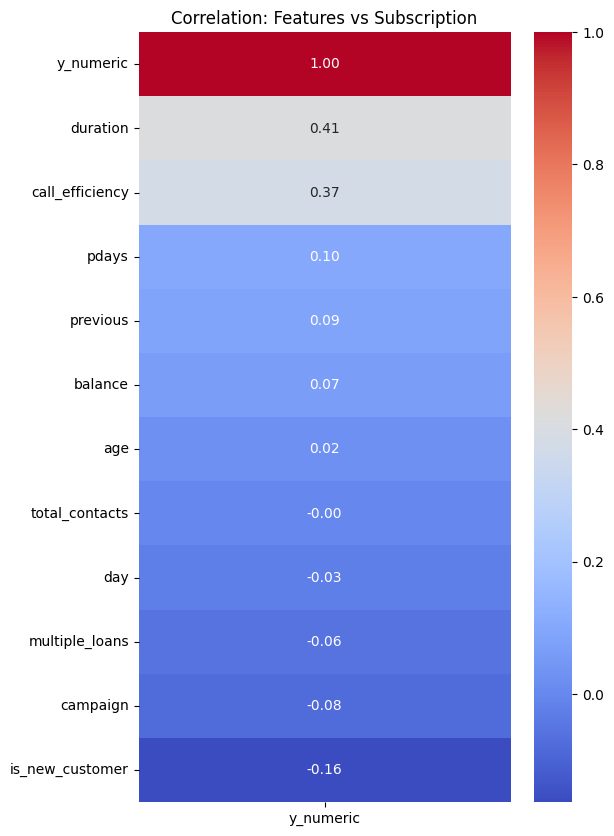

In [39]:
# 1. Map target to binary for correlation purposes
df_train['y_numeric'] = df_train['y'].map({'yes': 1, 'no': 0})

# 2. Select only numerical columns for the heatmap
numerical_df = df_train.select_dtypes(include=['number'])

# 3. Plot
plt.figure(figsize=(6, 10))
sns.heatmap(numerical_df.corr()[['y_numeric']].sort_values(by='y_numeric', ascending=False), 
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation: Features vs Subscription")
plt.show()

2. Categorical Analysis (The "Customer Profile")
We want to see the Subscription Rate across different categories. This is where your structural features (like job_type or quarter) will shine.
Since we have categorical columns like job, education, and poutcome, the best industrial practice is to use Stacked Bar Charts or Proportion Plots. This tells the bank: "Which segment of people actually says yes?"

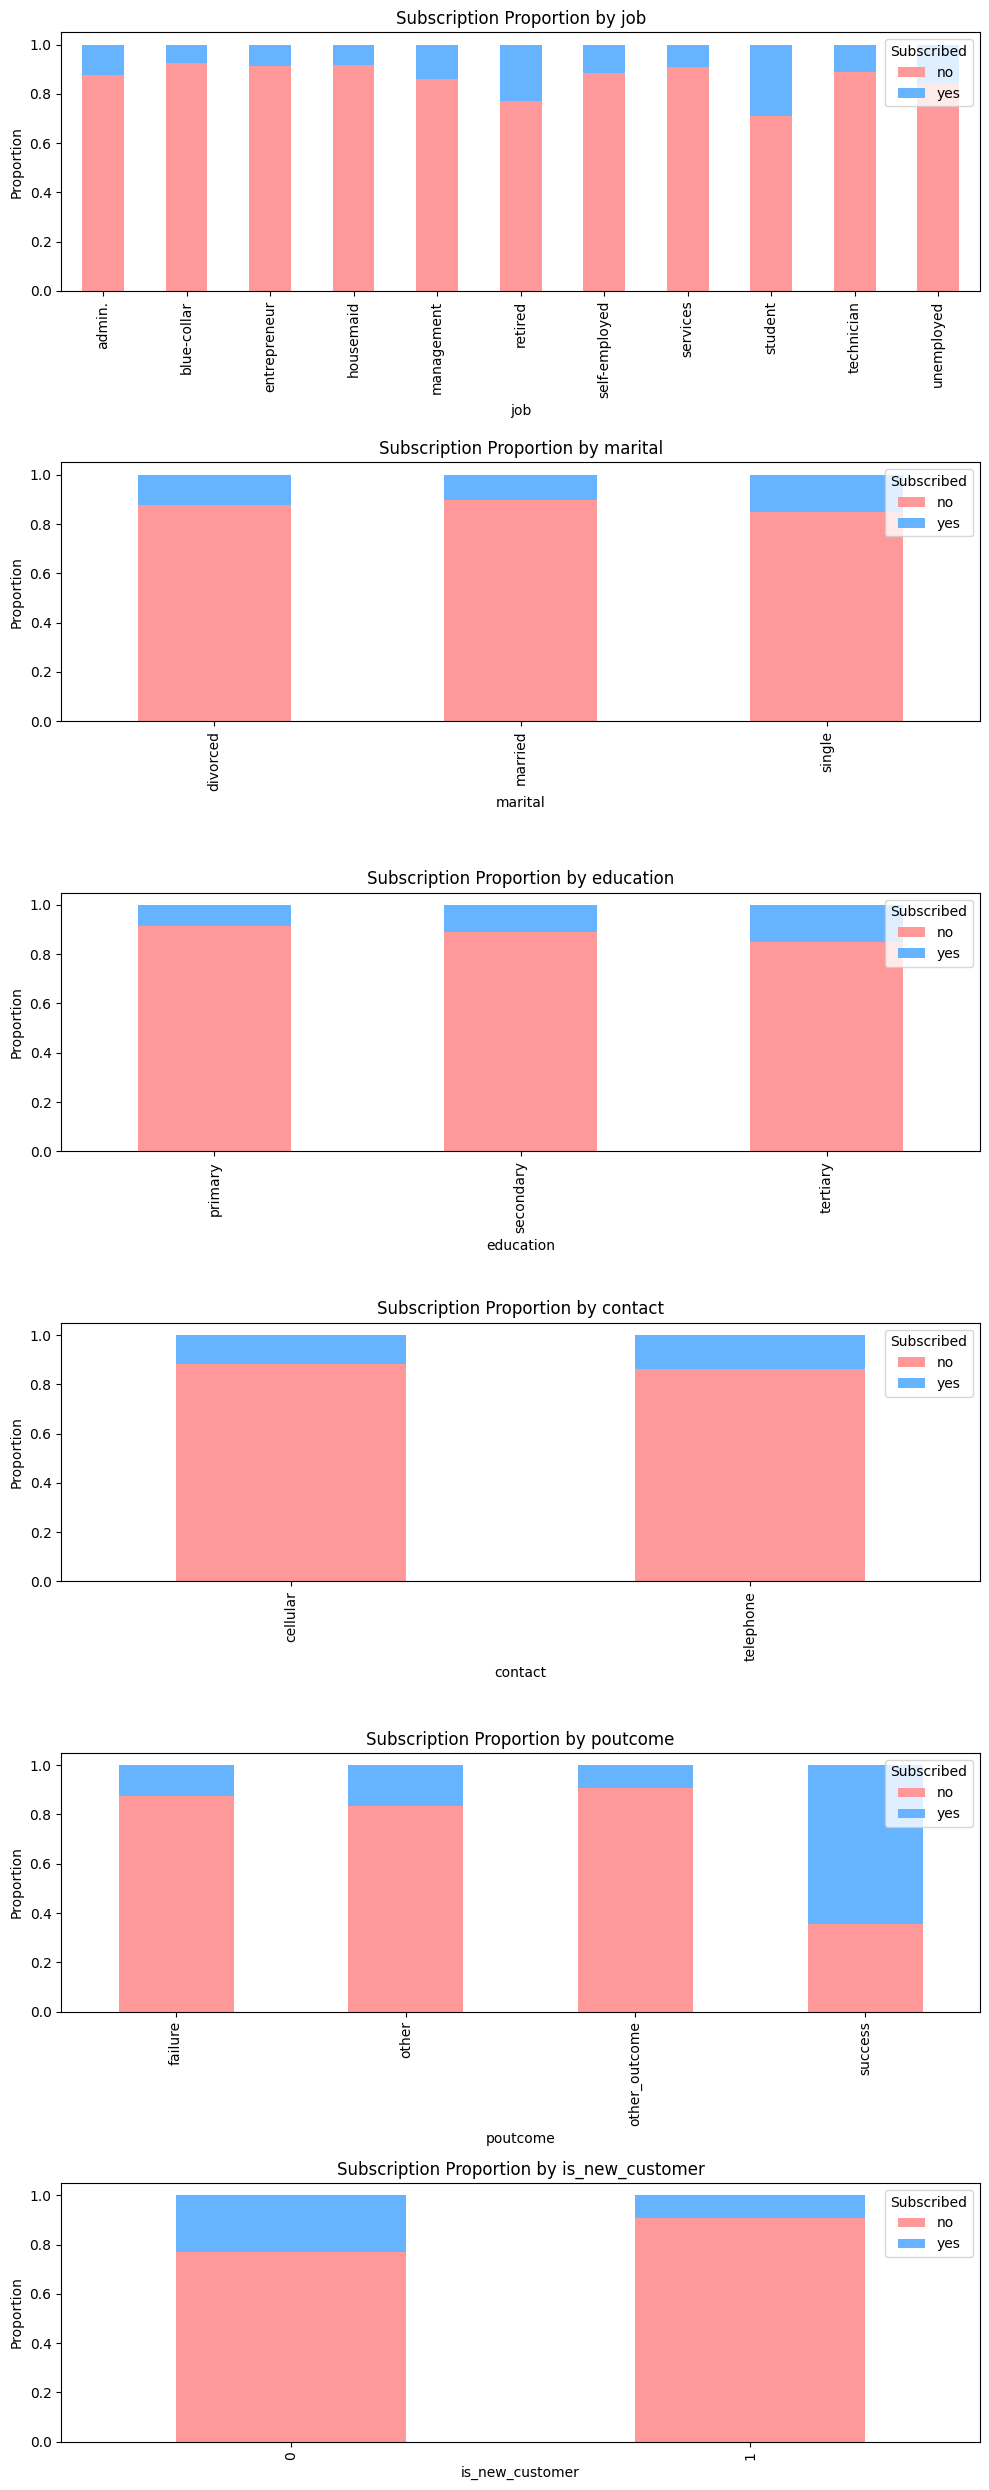

In [40]:
# Categorical Bivariate: Percentage of success per category
cat_cols = ['job', 'marital', 'education', 'contact', 'poutcome', 'is_new_customer']

fig, axes = plt.subplots(len(cat_cols), 1, figsize=(10, 25))

for i, col in enumerate(cat_cols):
    # Calculate the percentage of 'yes' for each category
    prop_df = df_train.groupby(col)['y'].value_counts(normalize=True).unstack().fillna(0)
    prop_df.plot(kind='bar', stacked=True, ax=axes[i], color=['#ff9999','#66b3ff'])
    axes[i].set_title(f'Subscription Proportion by {col}')
    axes[i].set_ylabel('Proportion')
    axes[i].legend(title='Subscribed', loc='upper right')

plt.tight_layout()
plt.show()

What to Look For in Your Results:
is_new_customer (Your Feature): If the proportion of 'yes' is significantly higher for new customers than for those with pdays > 0, your engineering was a success.

poutcome: In banking, "Success" in a previous campaign is usually the #1 predictor of success in the current one. This plot should confirm that.

call_efficiency (In Heatmap): Check if this has a higher correlation than the raw duration. If it does, you've created a more "dense" signal for the model.

3. Numerical Distribution (The "Behavioral Split")
How do "Yes" customers differ from "No" customers in terms of their balance or call duration? Because we capped the outliers earlier, these boxplots will actually be readable.

Since you have already capped the outliers, this is the perfect time to visualize the "gap" in behavior. In a banking campaign, we look for displacement: does the "Yes" group significantly shift away from the "No" group on the X-axis?

Here is the code to visualize the behavioral split for your numerical variables and your engineered features.

📊 Numerical Distribution Analysis (Bivariate)
We will use Boxplots to see the quartiles and KDE Plots (Density) to see where the "mass" of the customers sits.

C:\Users\jalpa\AppData\Local\Temp\ipykernel_37328\3567225263.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='y', y=col, data=df_train, ax=axes[i, 0], palette='Set2')
C:\Users\jalpa\AppData\Local\Temp\ipykernel_37328\3567225263.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='y', y=col, data=df_train, ax=axes[i, 0], palette='Set2')
C:\Users\jalpa\AppData\Local\Temp\ipykernel_37328\3567225263.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='y', y=col, data=df_train, ax=axes[i, 0], palette='Set2')
C:\Users\jalpa\AppData\Lo

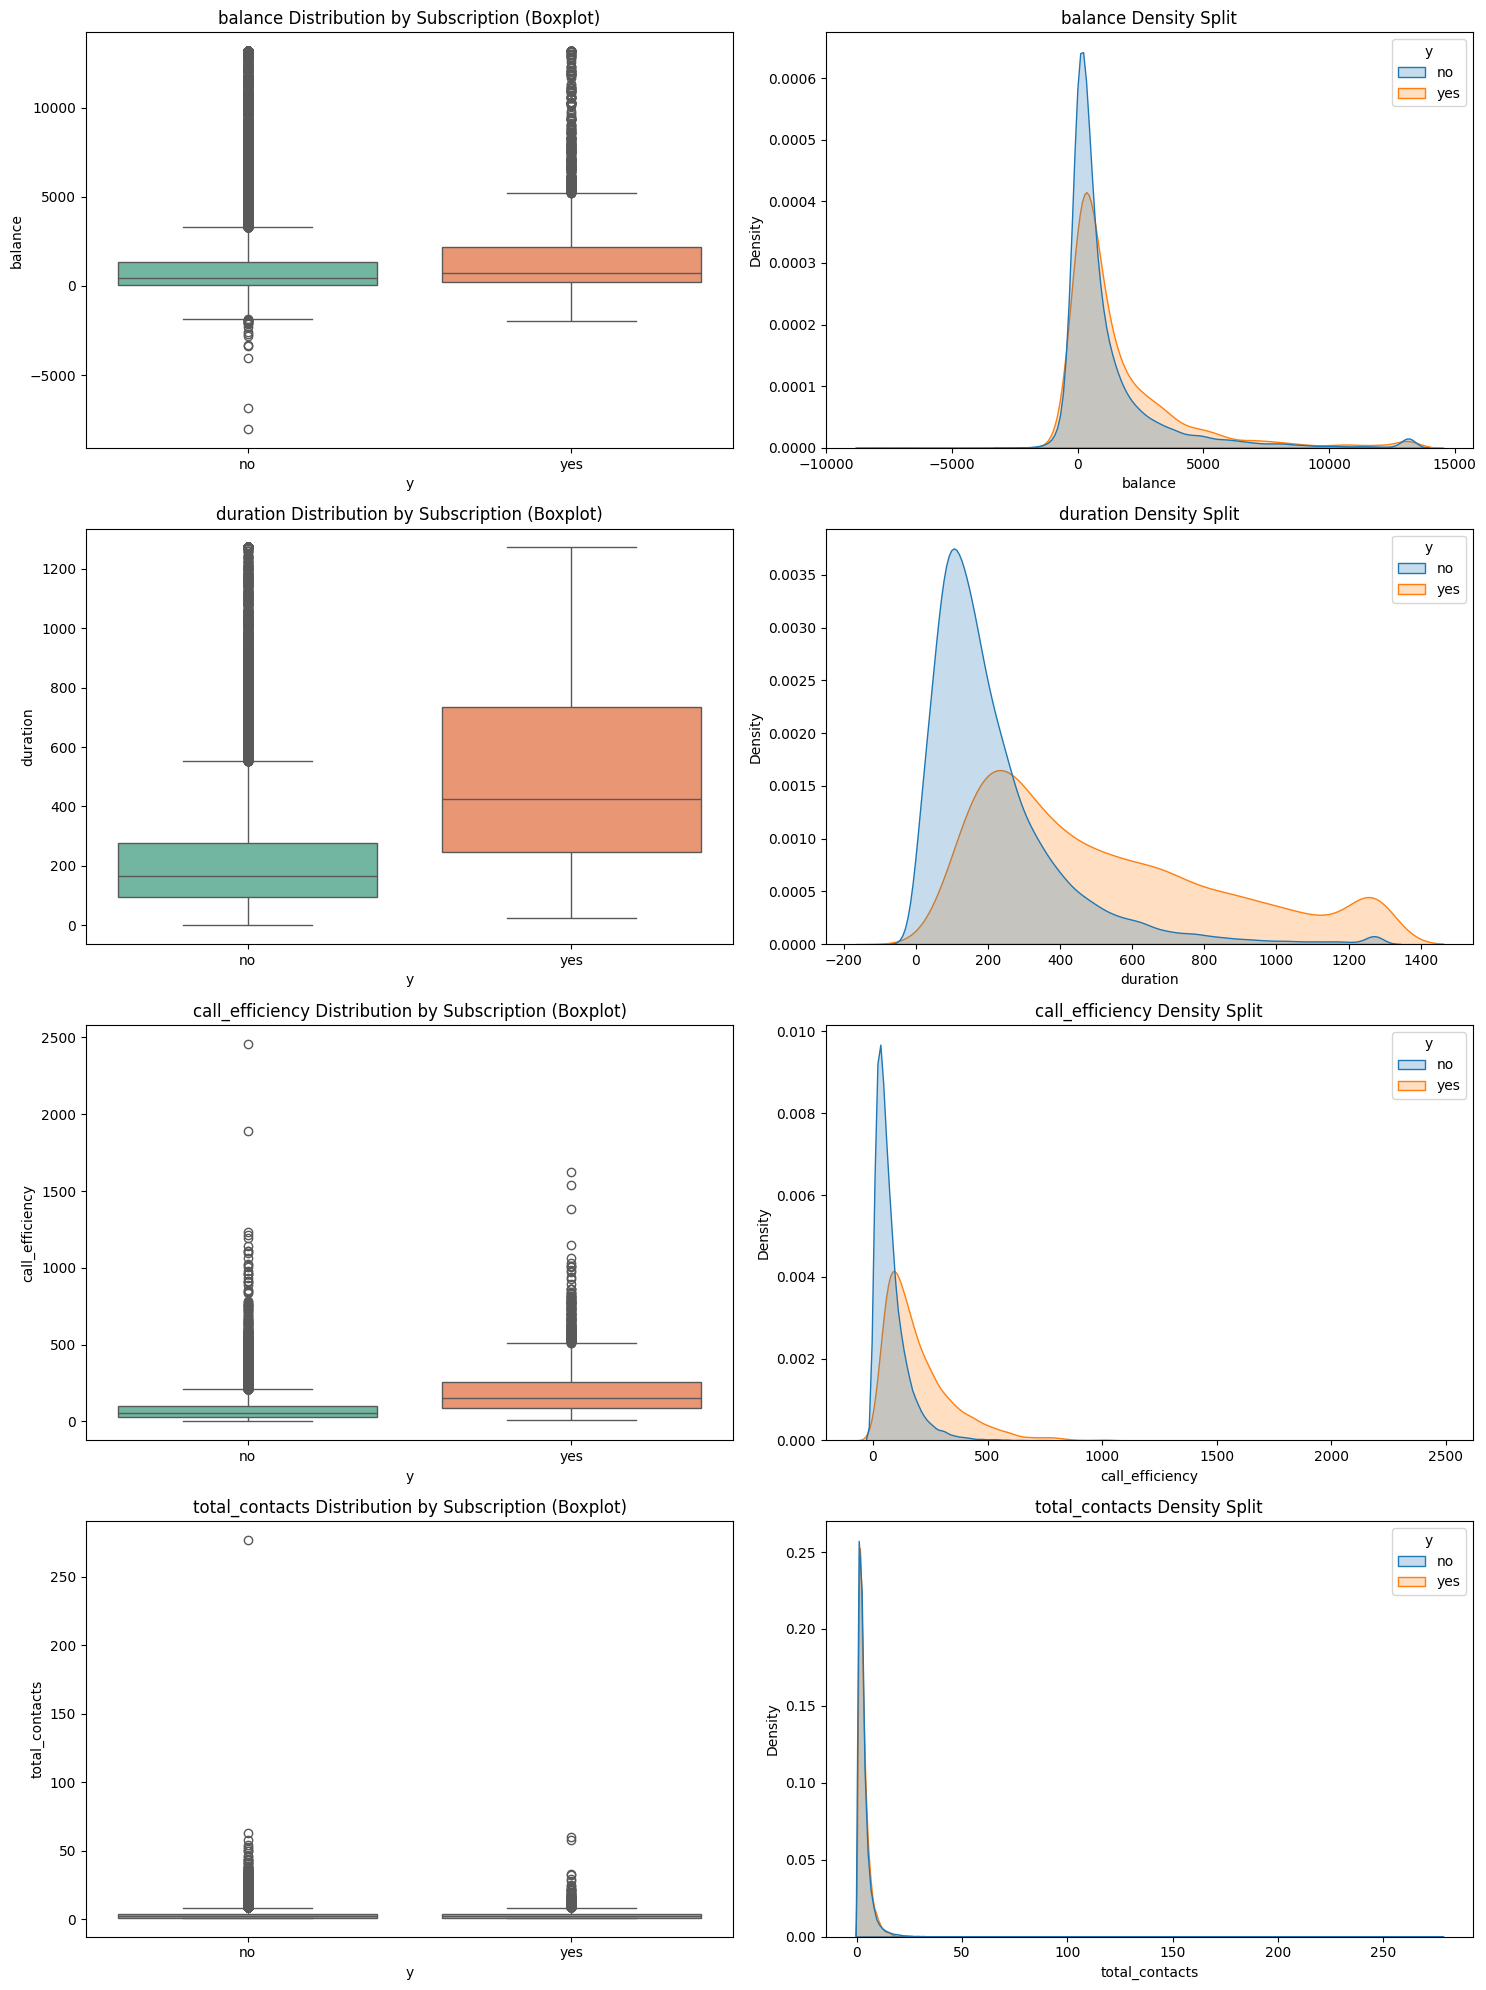

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Columns to analyze
num_cols = ['balance', 'duration', 'call_efficiency', 'total_contacts']

# Create a multi-plot grid
fig, axes = plt.subplots(len(num_cols), 2, figsize=(15, 20))

for i, col in enumerate(num_cols):
    # 1. Boxplot - Shows medians and spreads clearly
    sns.boxplot(x='y', y=col, data=df_train, ax=axes[i, 0], palette='Set2')
    axes[i, 0].set_title(f'{col} Distribution by Subscription (Boxplot)')
    
    # 2. KDE Plot - Shows the "overlap" between Yes and No
    sns.kdeplot(data=df_train, x=col, hue='y', common_norm=False, ax=axes[i, 1], fill=True)
    axes[i, 1].set_title(f'{col} Density Split')

plt.tight_layout()
plt.show()

How to Interpret the "Behavioral Split"
1. Duration & Call Efficiency (The "Engagement" Signal)
You will likely see that the "Yes" KDE plot is shifted significantly to the right.

Industrial Insight: If the medians are far apart, these features are your "Levers." The bank can practically use this to say, "If a call lasts less than X seconds, the probability of conversion drops below 10%."

2. Balance (The "Capacity" Signal)
Even after capping, you might notice that the "No" group has a higher density at very low or negative balances.

Industrial Insight: If the "Yes" boxplot is higher, it confirms that the product is reaching the intended affluent demographic.

3. Total Contacts (The "Fatigue" Signal)
Watch the "Yes" KDE for total_contacts. Usually, it peaks early (2-3 contacts) and then crashes.

Industrial Insight: This helps you identify Diminishing Returns. If the density of "Yes" disappears after 5 contacts, the bank is wasting money calling people a 6th time.

C:\Users\jalpa\AppData\Local\Temp\ipykernel_37328\586938155.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='y', y='balance', data=df_train, ax=axes[0], palette='Set2')
C:\Users\jalpa\AppData\Local\Temp\ipykernel_37328\586938155.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='y', y='call_efficiency', data=df_train, ax=axes[1], palette='Set2')


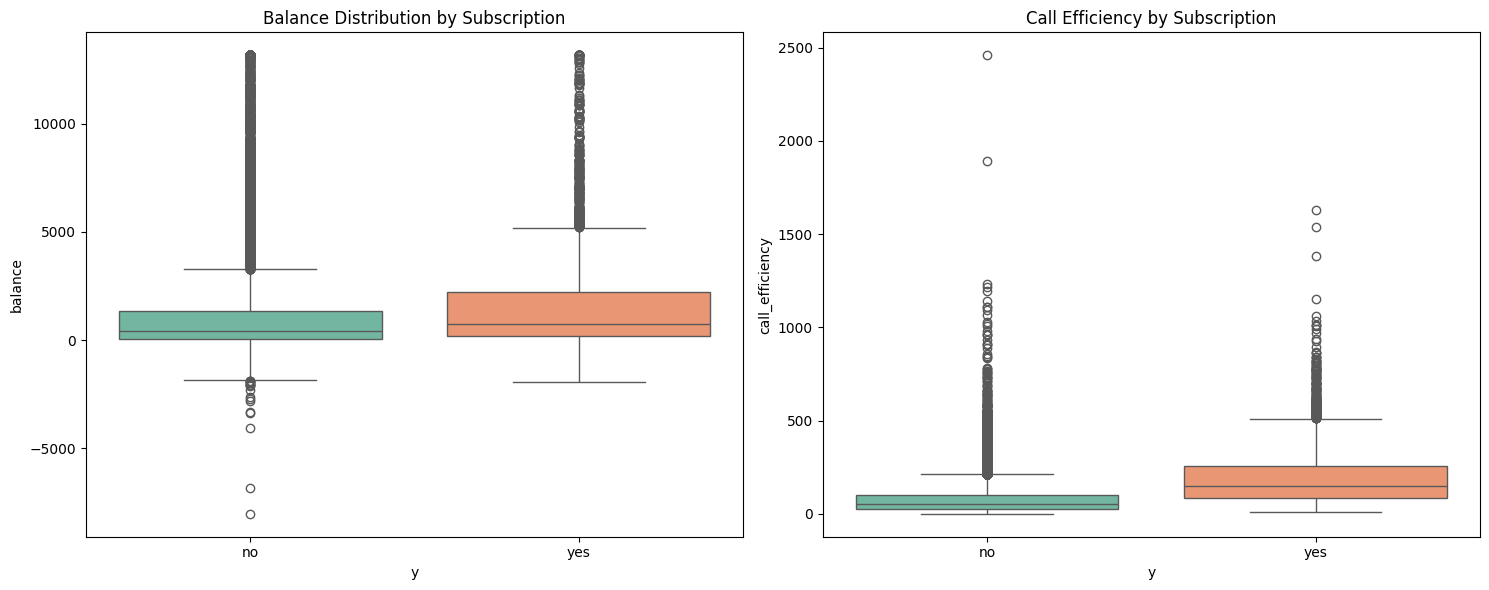

In [42]:
# Comparing behavior across target
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Balance vs Y
sns.boxplot(x='y', y='balance', data=df_train, ax=axes[0], palette='Set2')
axes[0].set_title('Balance Distribution by Subscription')

# Call Efficiency vs Y (Your engineered feature!)
sns.boxplot(x='y', y='call_efficiency', data=df_train, ax=axes[1], palette='Set2')
axes[1].set_title('Call Efficiency by Subscription')

plt.tight_layout()
plt.show()

The "Engagement" Signal (duration & call_efficiency)
The Gap: If the y=1 box is completely "floating" above the y=0 box, you have High Predictive Power.

Bank Policy: You can recommend a "Minimum Talk Time" (MTT). If a salesperson can't keep a client on the phone for at least the "Lower Whisker" of the successful boxplot, they shouldn't bother recording it as a lead.

B. The "Capacity" Signal (balance)
The Floor: If the y=1 boxplot has a "Lower Whisker" that starts at €500, then anyone with less than €500 is technically an "unqualified lead."

Bank Policy: Use this as a Filter. Don't waste marketing dollars calling customers who fall into the bottom 25% of the y=0 balance distribution.

C. The "Fatigue" Signal (total_contacts)
The Crash Point: In your KDE plot, look at where the "Yes" line intersects the "No" line for the last time.

Bank Policy: This is your Stop-Loss. If the conversion rate crashes after 4 contacts, you create a "Hard Cap" in the CRM system to prevent any customer from being called a 5th time.

4. Interactive Effects (The "Marketing Sweet Spot")
Sometimes one variable behaves differently depending on another. Let’s look at how duration affects success across different contact types.

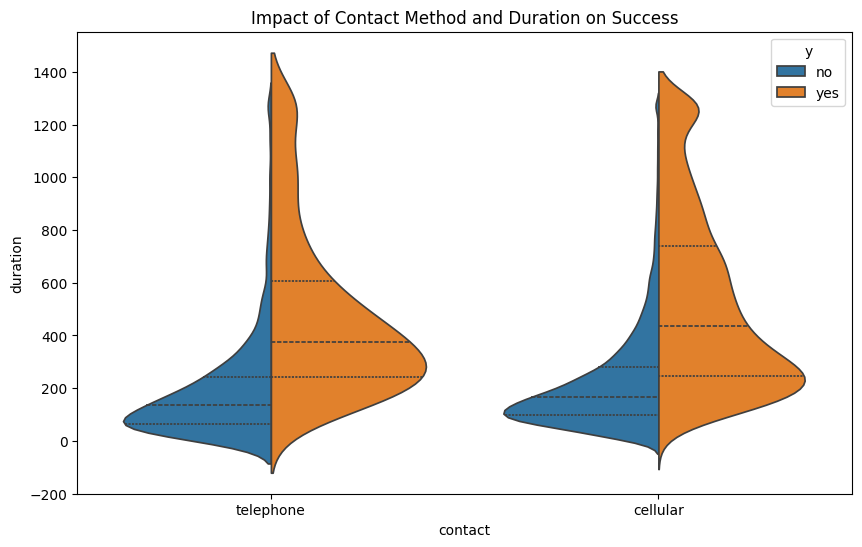

In [43]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='contact', y='duration', hue='y', data=df_train, split=True, inner="quart")
plt.title('Impact of Contact Method and Duration on Success')
plt.show()

The Interaction Effect (Violin Plot Analysis)
The violinplot of contact vs duration split by y is a powerful "Efficiency Map."

Cellular vs. Telephone: You might notice that 'cellular' calls have a different "width" (density) for success than 'telephone' (landline) calls.

The "Long Tail" of Success: If the "Yes" (blue/green) side of the violin is much taller than the "No" side, it proves that Duration is a necessary condition for Success, but only for specific contact methods.

Strategic Takeaway: If landlines require 10 minutes for a "Yes" but mobile calls only require 4 minutes, the bank should shift its budget to mobile-first campaigns.

What to look for (The "Senior" Interpretation):
The "Red Line" in Bar Plots: If a category (like 'Student' or 'Retired') is significantly above the red dashed line, that is a high-value segment for the bank.

Call Efficiency: If your engineered call_efficiency shows a much tighter, higher distribution for "Yes" than "No," you have successfully created a strong predictor.

Negative Correlation: If multiple_loans has a strong negative correlation with y, it proves the "Financial Stress" hypothesis—people with too much debt don't open savings accounts.

One Final Check: Skewness
If your KDE plots still look like a "tall needle" on the left with a very long tail, even after capping, it means the data is still highly skewed. In the next phase (Transformation), we might need to apply a Log Transformation or a Power Transformer to help the model "see" the data more clearly.

3. Verification of Engineered Features
Look closely at your call_efficiency boxplot.

Does it show a cleaner separation than the raw duration boxplot?

If the "Yes" and "No" boxes overlap less in call_efficiency than they do in duration, you have successfully reduced "noise" and created a feature that is easier for a Machine Learning model to "split."

**Saving data**

In an industrial workflow, saving your cleaned and engineered training and testing sets separately is a standard requirement for Reproducibility.

If you ever need to restart your kernel or hand this over to another teammate, you don't want to re-run the entire cleaning and engineering logic. You want to start exactly where you left off.

💾 Saving the "Checkpoint"
Since you have already done the hard work of handling unknowns, capping outliers, and creating new features, we will save these as .csv files.

In [44]:
# Save the Training Set (which contains the 'y' labels)
df_train.to_csv('bank_train_cleaned.csv', index=False)

# Save the Test Set (ensuring it's in the same format)
# If you haven't combined X_test and y_test yet:
df_test = X_test.copy()
df_test['y'] = y_test
df_test.to_csv('bank_test_cleaned.csv', index=False)

print("Files saved successfully: 'bank_train_cleaned.csv' and 'bank_test_cleaned.csv'")

Files saved successfully: 'bank_train_cleaned.csv' and 'bank_test_cleaned.csv'
